# Assign land cover to FPA FOD wildfires
- Use MODIS land cover data for the best guess of land cover type burned by a given FPA-FOD wildfire. 
- Assume spherical burn scar around FPA FOD fire lat lon location. Use that scar to estimate the types of land cover burned by a fire. 
- The land cover data are 0.5 x 0.5 km, so many of the fires in FPA FOD will essentially have point estimate land cover types given the size of the grid. 


Consider impact of going from a burn area estimate on a slope to a flat world for the modis burn area. This may require using overlap only for assigning proportions of the assigned burn area value.  

# TODO: Make this an implementation of the class() where grid overlap calculations are performed. And make this good for an example

In [1]:
area_of_modis_cell = (0.5*1000.)**2
print str(area_of_modis_cell) + " m2: area of 0.5 x 0.5 degree MODIS grid cell at equator"

m2_per_acre = 4046.86 # m2/acres
acres_per_cell = area_of_modis_cell / m2_per_acre

print str(acres_per_cell) + ": acres per modis land cover grid cell"

250000.0 m2: area of 0.5 x 0.5 degree MODIS grid cell at equator
61.7762907538: acres per modis land cover grid cell


In [5]:
import gdal # For working with the Geotiff. 
import os
import numpy as np
from matplotlib import pylab as plt
# http://geopandas.org/set_operations.html
from shapely.geometry import Polygon, Point
import geopandas
import pandas as pd

year = 2005

%matplotlib inline

| Value        | Label          |
| -------------|:-------------|
|0 | Water|
|1|Evergreen Needleleaf forest|
|2|Evergreen Broadleaf forest|
|3|Deciduous Needleleaf forest|
|4|Deciduous Broadleaf forest|
|5|Mixed forest|
|6|Closed shrublands|
|7|Open shrublands|
|8|Woody savannas|
|9|Savannas|
|10|Grasslands|
|11|Permanent wetlands|
|12|Croplands|
|13|Urban and built-up|
|14|Cropland/Natural vegetation mosaic|
|15|Snow and ice|
|16|Barren or sparsely vegetated|

In [3]:
# Make that nice table into a dictionary that can be called. 
LC_dict = {0:"Water",
           1:"Evergreen Needleleaf forest",
           2:"Evergreen Broadleaf forest",
           3:"Deciduous Needleleaf forest",
           4:"Deciduous Broadleaf forest",
           5:"Mixed forest",
           6:"Closed shrublands",
           7:"Open shrublands",
           8:"Woody savannas",
           9:"Savannas",
           10:"Grasslands",
           11:"Permanent wetlands",
           12:"Croplands",
           13:"Urban and built-up",
           14:"Cropland/Natural vegetation mosaic",
           15:"Snow and ice",
           16:"Barren or sparsely vegetated"
          }

This means that the 0.5 km modis land cover can resolve sub wildfire burn scar land cover types, i.e. it is and should be possible to estimate the different land covers that are consumed by large wildfires. 

### One time operations
- MODIS land cover data loaded into the workspace
- conversion factors
- crs

In [4]:
def get_land_cover_grid():

	# Get Land cover as array using gdal. This is a huge file.
	dataDir = os.path.join("..", "..", "metSpreadData", "GIS")
	f = os.path.join(dataDir, "LCType.tif")
	gtif = gdal.Open( f )
	LC_data = np.array(gtif.GetRasterBand(1).ReadAsArray())

	print "Shape of the LC data:"
	print LC_data.shape

	# Get the coordinates
	width  = gtif.RasterXSize
	height = gtif.RasterYSize
	gt     = gtif.GetGeoTransform()

	print "Width: " + str(width)
	print "Height: " + str(height)
	print "gtiff.GetGeoTransform() returned attributes"
	print gt

	minx = gt[0]
	miny = gt[3] + width*gt[4] + height*gt[5]
	maxx = gt[0] + width*gt[1] + height*gt[2]
	maxy = gt[3]

	print "Printing the coordinate limits as defined here:"
	print "minx " + str(minx)
	print "maxx " + str(maxx)
	print "miny " + str(miny)
	print "maxy " + str(maxy)

	# Logically speaking, the data should span the length of the min and max coord values
	# by the number of dim size. Becuase these go to the limits of the data, they
	# represent upper left hand corners for these data.
	LC_x = np.linspace(minx, maxx, LC_data.shape[1])
	LC_y = np.linspace(maxy, miny, LC_data.shape[0])


	# Subset these data, as we only have wildfires in North America. This will
	# save memory! We only need data in northern hemisphere for sure.
	x_mask = np.where( (LC_x >= -169.) & (LC_x <= -60.) )[0]
	y_mask = np.where( (LC_y >= 15.) & (LC_y <= 71.5) )[0]

	LC_x_return = LC_x[x_mask]
	LC_y_return = LC_y[y_mask]
	LC_return   = LC_data[np.ix_(y_mask, x_mask)]

	print("---------------------------------------")
	print("Dimensions of returned subset LC data")

	print "Shape of the LC data:"
	print LC_return.shape

	print "Width: " + str(len(LC_x_return))
	print "Height: " + str(len(LC_y_return))
	print("---------------------------------------")

	return LC_return, LC_x_return, LC_y_return

LC_data, LC_x, LC_y = get_land_cover_grid()

################################################################################
# Perform one time operations that should not be done in the loop
################################################################################

# In order to subset the land cover grid around a fire's location, need to
# know the width of the grid in deg units. Use max observed in the data, as
# it is ok to make a slightly larger than needed area to check fire overlap.
LC_grid_dx = np.max(np.diff(LC_x))
LC_grid_dy = np.max(np.abs(np.diff(LC_y)))

# Unit conversion
m2_per_acre = 4046.86

# CRS projection to assign to grid boxes when made into polygons
crs_assign = {'init':'+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'}

Shape of the LC data:
(43200, 86400)
Width: 86400
Height: 43200
gtiff.GetGeoTransform() returned attributes
(-179.9999999979966, 0.004166666666666719, 0.0, 89.9999999919177, 0.0, -0.004166666666666719)
Printing the coordinate limits as defined here:
minx -179.999999998
maxx 180.000000002
miny -90.0000000081
maxy 89.9999999919
---------------------------------------
Dimensions of returned subset LC data
Shape of the LC data:
(13560, 26160)
Width: 26160
Height: 13560
---------------------------------------


## Load FPA FOD wildfires and loop through desired subset 
- http://geopandas.org/data_structures.html

In [38]:
################################################################################
# Read in the FPA FOD data
################################################################################
print("Reading in the wildfire dataframe...")
fire_dir = os.path.join("..","Data","Fire","FPA_FOD")
fpa_fod_file = os.path.join(fire_dir, "FPA_FOD_1992_2015_eco.csv")
FPA_FOD_all = pd.read_csv(fpa_fod_file)

# Subset FPA_FOD_all by the selected year.
year_mask = (FPA_FOD_all["FIRE_YEAR"] == year)
FPA_FOD   = FPA_FOD_all.iloc[year_mask.values]
nFires    = FPA_FOD.shape[0] # Each row is a wildfire

# Add land cover types as a new column in the FPA_FOD DataFrame
for new_row_name in LC_dict.values():
    FPA_FOD[new_row_name] = (np.zeros(nFires));

# I need to know where the LC_columns are in the FPA_FOD DataFrame
LC_columns = np.where(pd.Series(FPA_FOD.columns).isin(LC_dict.values()))[0]

# Add columns that will store information about the execution of the overlap 
# calculations
FPA_FOD["dArea"] = np.zeros(nFires)
FPA_FOD["percent_of_fire_area_overlaped"] = np.zeros(nFires)


print(FPA_FOD.shape)
# Preview these data, first 10 rows only
#FPA_FOD[0:10]

Reading in the wildfire dataframe...


/Users/sbrey/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


(88604, 59)


/Users/sbrey/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sbrey/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [39]:
# Find the HUMBOLT fire row

humboldt_row = np.where(FPA_FOD["FIRE_NAME"].values == "HUMBOLDT")
print humboldt_row

FPA_FOD.iloc[0,:] = FPA_FOD.iloc[66108,:]
nFires = 1


(array([ 4491, 17030, 66108]),)


In [40]:
FPA_FOD.iloc[0]

Unnamed: 0                                          1059559
FOD_ID                                              1271831
FPA_ID                                           FS-1430376
SOURCE_SYSTEM_TYPE                                      FED
SOURCE_SYSTEM                                   FS-FIRESTAT
NWCG_REPORTING_AGENCY                                    FS
NWCG_REPORTING_UNIT_ID                              USAZTNF
NWCG_REPORTING_UNIT_NAME              Tonto National Forest
SOURCE_REPORTING_UNIT                                  0312
SOURCE_REPORTING_UNIT_NAME            Tonto National Forest
LOCAL_FIRE_REPORT_ID                                     68
LOCAL_INCIDENT_ID                                        68
FIRE_CODE                                              BVK8
FIRE_NAME                                          HUMBOLDT
ICS_209_INCIDENT_NUMBER                      AZ-TNF-104/113
ICS_209_NAME                             Cave Creek Complex
MTBS_ID                               AZ

### Loop through fires

In [41]:
################################################################################
# LOOP through each fire
################################################################################
for fire_index in range(nFires):
    print(fire_index)
    if (fire_index%1000==0):
        print str(fire_index*1.0/nFires*100) + " percent complete"

    # FPA FOD FIRE_SIZE is in acres, lat and lon in decimal degrees.
    # NOTE: These methods assume that the lat lon provided are centriods.
    fire_size_acres = FPA_FOD["FIRE_SIZE"].iloc[fire_index]
    fire_lon = FPA_FOD["LONGITUDE"].iloc[fire_index]
    fire_lat = FPA_FOD["LATITUDE"].iloc[fire_index]

    # Need to get from acres to SI units so we can think about what this
    # size fire means in terms of a lat lon grid
    fire_area_m2 = fire_size_acres * m2_per_acre

    # Assuming the fire area is a circle, calculate radius from area
    # NOTE: Area needs to be in m**2
    fire_rad_m = np.sqrt(fire_area_m2/np.pi)

    # Subset the LC grid needed to encompas this circle. Create spatial extents
    # using local meters per degree values in the x and y directions.
    # NOTE: The coords of LC_grid units are degrees lon and lat.
    m_per_deg_lat = (111.*1000.) # ~111 km per deg and 1000 meter per km
    m_per_deg_lon = (111.*1000.) * np.cos(fire_lat * np.pi/180.) # 0 at pole, 90 deg N.

    # Fire radius needs to be expressed in terms of degrees for polygon creation
    fire_rad_deg =  fire_rad_m / m_per_deg_lat

    # Establish LC_grid extent where overlap calculations are needed
    # Add one LC_grid box width to make sure the circle is covered for very
    # small wildfires.
    minLat = fire_lat - (fire_rad_deg + LC_grid_dy)
    maxLat = fire_lat + (fire_rad_deg + LC_grid_dy)
    minLon = fire_lon - (fire_rad_deg + LC_grid_dy)
    maxLon = fire_lon + (fire_rad_deg + LC_grid_dy)

    # Mask these extends on the LC coordinates and grid
    lonIndex = np.where( ( (LC_x >= minLon) & (LC_x <= maxLon)) )[0]
    latIndex = np.where( ( (LC_y >= minLat) & (LC_y <= maxLat) ) )[0]
    LC_x_subset = LC_x[lonIndex]
    LC_y_subset = LC_y[latIndex]
    LC_subset   = LC_data[np.ix_(latIndex, lonIndex)]

    # Get a local dx dy for this subset of grid boxes
    LC_subset_dx = np.max(np.diff(LC_x_subset))
    LC_subset_dy = np.max(np.abs(np.diff(LC_y_subset)))

    # Make fire a circle shapely polygon object
    fire_poly = Point(fire_lon, fire_lat).buffer(fire_rad_deg)

    # NOTE: The definition of the polygon corners depends on whether the LC_grid_coords
    # NOTE: represent grid corners or grid centers.
    # TODO: Retain land cover information here.
    ncolumn = len(LC_x_subset)
    nrow    = len(LC_y_subset)

    # NOTE: This will break near edges of LC_subset.
    ij_count = 0
    LC_grid_polygon_list = [None] * (ncolumn * nrow)
    LC_cover = [None] * (ncolumn * nrow)
    for i in range(ncolumn):
        for j in range(nrow):
            # Get land cover for this grid box
            LC_cover[ij_count] = LC_subset[j, i]

            # where coords are top left of pixels.
            x0 = LC_x_subset[i]
            x1 = LC_x_subset[i] + LC_subset_dx
            y0 = LC_y_subset[j]
            y1 = LC_y_subset[j] - LC_subset_dy
            LC_grid_polygon_list[ij_count]  = Polygon([(x0, y0), (x1, y0), (x1, y1), (x0, y1)])
            ij_count = ij_count + 1 # Advance the count of created polygons

    # Create GeoSeries of local grid and fire
    grid_polys = geopandas.GeoSeries(LC_grid_polygon_list)
    fire_polys = geopandas.GeoSeries(fire_poly)

    # Setup geographic coordinate system for fire and grid boxes to live on.
    grid_polys.crs = crs_assign
    fire_polys.crs = crs_assign

    # Create GeoDataFrame, which have desirable properties and methods
    grid_polys_df = geopandas.GeoDataFrame({'geometry': grid_polys, 'grid_LC_val':LC_cover})
    fire_polys_df = geopandas.GeoDataFrame({'geometry': fire_polys, 'Fire':"FireName"})

    # Returns a DataFrame with only the geometries that are contained by both
    # GeoDataFrames. This is an expensive operation.
    res_intersection = geopandas.overlay(grid_polys_df, fire_polys_df, how='intersection')

    # Add the overlapping area to this intersection dataframe
    res_intersection['grid_overlap_fraction'] = pd.Series(res_intersection.area/fire_poly.area,
                                                          index=res_intersection.index)

    # Append Percent Overlap information to the intersection DataFrame
    res_intersection['percent_of_fire_area'] = pd.Series(res_intersection.area/fire_poly.area*100.,
                                                         index=res_intersection.index)
    # nRows is equal to the total number of land cover grid boxes that the fire circle area
    # overlaps. 
    nRows = res_intersection.shape[0]
    
    # Attributes to append to FPA FOD dataframe
    FPA_FOD["percent_of_fire_area_overlaped"].iloc[fire_index] = np.sum(res_intersection['percent_of_fire_area'])
    for res_row in range(nRows) :
       
        # Get the overlap area for this overlapping grid box in res_intersection
        area_to_add = res_intersection["grid_overlap_fraction"].iloc[res_row] * fire_size_acres
        
        # Translate land cover numeric to name for column indexing. i.e. where does that
        # overlapping area go? 
        LC_column_name = LC_dict[res_intersection["grid_LC_val"].iloc[res_row]]
        
        # Because grid boxes in res_intersection can be of the same LC_type, need to add to existing. 
        FPA_FOD[LC_column_name].iloc[fire_index] = (FPA_FOD[LC_column_name].iloc[fire_index] + area_to_add)
        
    # Sanity check, make sure the sum of the assigned land cover areas is very close to equal the area
    # of the fire. 
    dArea = np.sum(FPA_FOD.iloc[fire_index, LC_columns]) - fire_size_acres
    FPA_FOD["dArea"].iloc[fire_index] = dArea
    
print("For loop complete. Writing land cover appended dataframe to disk.")
    
# When the loop is complete, perform sanity checks on the data and append warnings
# to the file name. 
if np.max(np.abs(FPA_FOD["dArea"])) > -1e6:
    warnString = "_double_check_max_dArea"
elif (np.max(FPA_FOD["percent_of_fire_area_overlaped"]) < 99.):
    warnString = "_check_fire_overlap_percentages"
else:
    warnString = ""

# Done with looping through fires, write the large dataframe
#date_attributes = str(year) + "_months=" #+ str(min_month) + "-" + str(max_month)
#file_name = "FPA_FOD_with_MODIS_Land_Cover" + warnString + ".csv"
#save_name = os.path.join("..", "Data","Fire", "FPA_FOD", file_name)
#FPA_FOD.to_csv(save_name)

# Preview
#FPA_FOD.iloc[0:5]

0.0 percent complete


/Users/sbrey/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/sbrey/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sbrey/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


For loop complete. Writing land cover appended dataframe to disk.


/Users/sbrey/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [47]:
res_intersection

,grid_LC_val,Fire,geometry,grid_overlap_fraction,percent_of_fire_area
0,7,FireName,POLYGON ((-111.6617090455542 33.97944352252898...,6.174468e-07,6.174468e-05
1,7,FireName,POLYGON ((-111.6617090455542 33.97786985001557...,2.772374e-18,2.772374e-16
2,7,FireName,POLYGON ((-111.9700459476016 33.97786985001557...,3.635929e-16,3.635929e-14
3,7,FireName,POLYGON ((-111.9658792327091 33.97786985001557...,2.132181e-04,2.132181e-02
4,7,FireName,POLYGON ((-111.6783759051243 33.97786985001557...,3.635929e-16,3.635929e-14
5,7,FireName,POLYGON ((-111.6742091902318 33.97786985001557...,2.132181e-04,2.132181e-02
6,7,FireName,POLYGON ((-111.9742126624942 33.97786985001557...,3.635929e-16,3.635929e-14
7,7,FireName,POLYGON ((-111.9700459476016 33.97786985001557...,2.132181e-04,2.132181e-02
8,7,FireName,POLYGON ((-111.9617125178166 33.97786985001557...,1.240058e-27,1.240058e-25
9,7,FireName,POLYGON ((-111.9617125178166 33.97786985001557...,7.271943e-16,7.271943e-14


### Plot results of overlapping analysis for a fire

Fire Latitude: 33.97833333
Fire Longitude: -111.82277778
Fire Size Acres: 248310.0


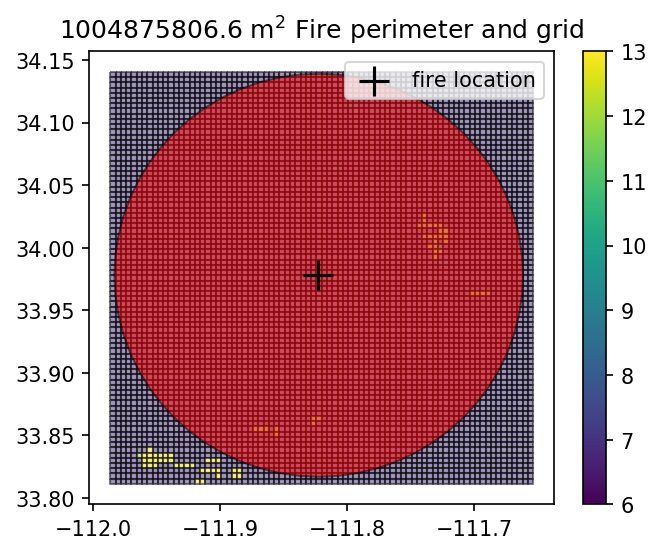

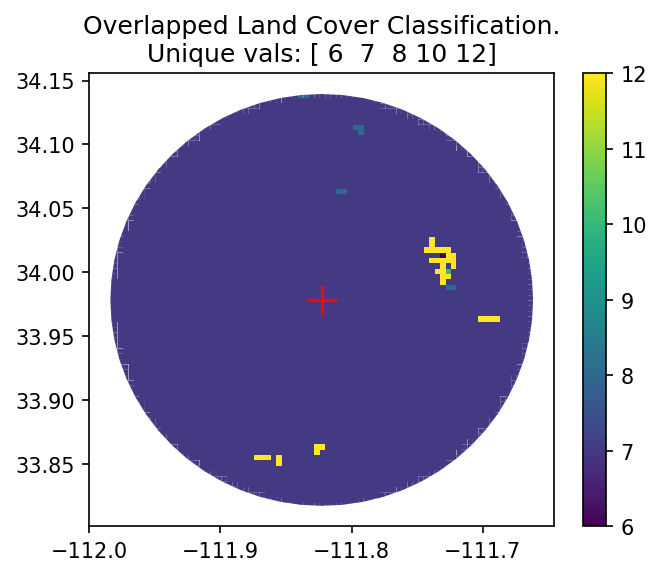

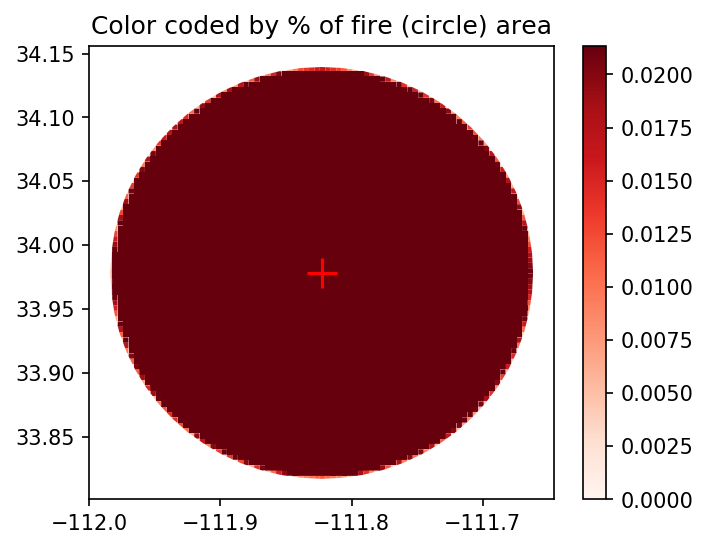

NameError: name 'proportion_area' is not defined

<Figure size 750x600 with 0 Axes>

In [46]:
print "Fire Latitude: " + str(fire_lat)
print "Fire Longitude: " + str(fire_lon)
print "Fire Size Acres: " + str(FPA_FOD["FIRE_SIZE"].values[fire_index])

# Show the geodataframe rectangles and fire circle
fig, ax = plt.subplots(1, 1, dpi=150, figsize=(5,4))
grid_polys_df.plot(ax=ax, column='grid_LC_val' ,alpha=0.5, edgecolor='black', legend=True);
fire_polys_df.plot(ax=ax, color='red', alpha=0.5, edgecolor='black');
plt.scatter(fire_lon, fire_lat, color="black",marker="+", label="fire location", s=200)
plt.title(str(fire_area_m2) +" m$^{2}$ Fire perimeter and grid")
plt.legend()
plt.show()

# Show the overlapping grid cells and color code by land cover type
fig, ax = plt.subplots(1, 1, dpi=150, figsize=(5,4))
res_intersection.plot(ax=ax, column='grid_LC_val', legend=True) # edgecolor='black'
plt.scatter(fire_lon, fire_lat, color="red", marker="+", label="fire location", s=200)
plt.title("Overlapped Land Cover Classification.\nUnique vals: " 
          + str(np.unique(res_intersection["grid_LC_val"])))
plt.show()

# Show what percent of the circle area is made up by each overlapping grid box. 
fig, ax = plt.subplots(1, 1, dpi=150, figsize=(5,4))
res_intersection.plot(ax=ax, column='percent_of_fire_area', cmap="Reds", legend=True) # edgecolor='black',
plt.scatter(fire_lon, fire_lat, color="red", marker="+", label="fire location", s=200)
plt.title("Color coded by % of fire (circle) area")
plt.show()

# Show a bar chart that shows the spatial distribution of land-cover
plt.figure(dpi=150, figsize=(5,4))
plt.bar(x=res_intersection["grid_LC_val"], height=proportion_area)
plt.xticks(rotation='vertical')
plt.xlabel("land cover type consumed")
plt.ylabel("Proportion Fire Burn Area")
plt.title("Fraction of Land Cover Consumed by fire")
plt.show()

print "Max percent of circle area for a single gridcell: " + str(np.max(res_intersection['percent_of_fire_area']))
print "Min percent of circle area for a single gridcell: " + str(np.min(res_intersection['percent_of_fire_area']))
print "Sum of all percent overlap values: " + str(np.sum(res_intersection['percent_of_fire_area']))

# Look at the dataframe
res_intersection

# TODO:
- Run for all FPA FOD wildfires
- Present the differences from point estimates.This will help us figure out if all this effort does anything and if it does, what? 
- Get Monique's opinion, am I missing something obvious? 
- Where available, compare to MTBS classifications? 